### Process Train/Test Split

In [1]:
import os
import sys
import numpy as np
import torch
import sklearn as skl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
X_orig = torch.load("../../../datasets/processed/HouseholdElectricity/X.pt")

In [3]:
def train_test_split_he(X,train_days,test_days):
    return X[:,:train_days*24], X[:,train_days*24:(train_days+test_days)*24]

X_train_orig, X_test_orig = train_test_split_he(X_orig,60,10) 

In [15]:
def setup_xy_he(X,past_times,fut_times):
    n,m = X.shape
    Xhs = []
    Yhs = []
    for house in range(n-2):
        Xis = []
        Yis = []
        for i in range(past_times,m+1-fut_times):
            Xi = torch.cat((X[house,i-past_times:i], # load
                            X[-2,i-past_times:i], # temp
                            X[-1,i].unsqueeze(0),))  # weekday/weekend
            Yi = X[house,i:i+fut_times]
            Xis.append(Xi)
            Yis.append(Yi)
        Xhs.append(torch.stack(Xis))
        Yhs.append(torch.stack(Yis))
    return torch.stack(Xhs), torch.stack(Yhs)

X_train, Y_train = setup_xy_he(X_train_orig,4,1)
X_test, Y_test = setup_xy_he(X_test_orig,4,1)

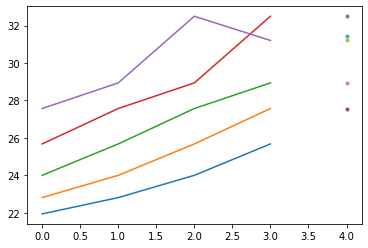

In [107]:
plt.plot(range(4),X_train[0,:5,:4].T)
plt.plot(4*np.ones((1,5)),Y_train[0,:5,0].unsqueeze(0),'.')
plt.show()

### Baselines

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model, svm, neural_network

In [25]:
# extract household 1 and 2 data

Xr1, Yr1 = X_train[0,:,:].numpy(), Y_train[0,:,0].numpy()
Xt1, Yt1 = X_test[0,:,:].numpy(), Y_test[0,:,0].numpy()
Xr2, Yr2 = X_train[1,:,:].numpy(), Y_train[1,:,0].numpy()
Xt2, Yt2 = X_test[1,:,:].numpy(), Y_test[1,:,0].numpy()

#### LinReg

In [31]:
house1lr = linear_model.LinearRegression()
house1lr.fit(Xr1,Yr1)
house1lr_pred = house1lr.predict(Xt1)

print("MAPE: %f" %(mean_absolute_error(Yt1,house1lr_pred)))
print("MSE: %f" %(mean_squared_error(Yt1,house1lr_pred)))

MAPE: 1.089018
MSE: 2.324192


In [32]:
house2lr = linear_model.LinearRegression()
house2lr.fit(Xr2,Yr2)
house2lr_pred = house1lr.predict(Xt2)

print("MAPE: %f" %(mean_absolute_error(Yt2,house2lr_pred)))
print("MSE: %f" %(mean_squared_error(Yt2,house2lr_pred)))

MAPE: 1.342140
MSE: 2.994055


#### SVR

In [38]:
house1svr = svm.SVR(kernel = 'linear')
house1svr.fit(Xr1,Yr1)
house1svr_pred = house1svr.predict(Xt1)

print("MAPE: %f" %(mean_absolute_error(Yt1,house1svr_pred)))
print("MSE: %f" %(mean_squared_error(Yt1,house1svr_pred)))

MAPE: 1.046655
MSE: 2.252988


In [57]:
house2svr = svm.SVR(kernel = 'linear')
house2svr.fit(Xr2,Yr2)
house2svr_pred = house2svr.predict(Xt2)

print("MAPE: %f" %(mean_absolute_error(Yt2,house2svr_pred)))
print("MSE: %f" %(mean_squared_error(Yt2,house2svr_pred)))

MAPE: 1.224588
MSE: 2.750958


####  FNN

In [71]:
from sklearn.preprocessing import StandardScaler

sc1 = StandardScaler()
sc1.fit(Xr1)
Xr1s = sc1.transform(Xr1)
Xt1s = sc1.transform(Xt1)

sc2 = StandardScaler()
sc2.fit(Xr2)
Xr2s = sc2.transform(Xr2)
Xt2s = sc2.transform(Xt2)

# unused

In [97]:
house1nn = neural_network.MLPRegressor(hidden_layer_sizes = (40,40,40), 
                                       solver='adam', random_state=1,
                                       learning_rate='adaptive', alpha=.1)
house1nn.fit(Xr1,Yr1)

house1nn_pred = house1nn.predict(Xt1)

print("MAPE: %f" %(mean_absolute_error(Yt1,house1nn_pred)))
print("MSE: %f" %(mean_squared_error(Yt1,house1nn_pred)))

MAPE: 1.077050
MSE: 2.185933


In [90]:
house2nn = neural_network.MLPRegressor(hidden_layer_sizes = (40,40,40), 
                                       solver='adam', random_state=1,
                                       learning_rate='adaptive', alpha=.1)
house2nn.fit(Xr2,Yr2)

house2nn_pred = house2nn.predict(Xt2)

print("MAPE: %f" %(mean_absolute_error(Yt2,house2nn_pred)))
print("MSE: %f" %(mean_squared_error(Yt2,house2nn_pred)))

MAPE: 1.561057
MSE: 4.306277
